In [1]:
import pathlib
import sys

ROOT = pathlib.Path(".").absolute().parent.parent
sys.path.append(str(ROOT))

from utils.metrics import (
    plot_classification_report,
    print_scores,
    plot_tsne_features
)
from pycave.bayes.gmm.estimator import GaussianMixture
from utils.dataset import get_numpy_dataset_from_dataloader
import os
from datasets.SPCUP22DataModule import SPCUP22DataModule
from features.audio import MFCC, CQCC
from utils.config import load_config_file
from torchvision.transforms import Compose
import numpy as np

### Set this according to your system

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "6"

## GMM + MFCC

### Load config

In [3]:
train_config = load_config_file(ROOT.joinpath("config", "train_params.yaml"))[
    "gmm"
]

### Hyperparams

In [4]:
n_mfcc = train_config["features"]["n_mfcc"]
hop_length = train_config["features"]["hop_length"]

In [5]:
batch_size = 200
mfcc_extractor = MFCC(n_mfcc=n_mfcc, hop_length=hop_length)
transforms = Compose([mfcc_extractor])

### Data module

#### Without augmentations

In [6]:
data_module = SPCUP22DataModule(
    batch_size=batch_size,
    dataset_root=str(ROOT.joinpath("data", "raw_audio", "spcup22").absolute()),
    should_include_unseen_in_training_data=True,
    transform=transforms,
)
data_module.prepare_data()
data_module.setup()

Skipping downloading [/home/iubnlp/spcup22/SPCUP2022/data/raw_audio/spcup22/spcup_2022_training_part1.zip]...
Skipping downloading [/home/iubnlp/spcup22/SPCUP2022/data/raw_audio/spcup22/spcup_2022_unseen.zip]...
Skipping downloading [/home/iubnlp/spcup22/SPCUP2022/data/raw_audio/spcup22/part1_aug.zip]...
Skipping downloading [/home/iubnlp/spcup22/SPCUP2022/data/raw_audio/spcup22/part2_aug.zip]...
Skipping downloading [/home/iubnlp/spcup22/SPCUP2022/data/raw_audio/spcup22/spcup_2022_eval_part1.zip]...
Skipping downloading [/home/iubnlp/spcup22/SPCUP2022/data/raw_audio/spcup22/spcup_2022_eval_part2.zip]...


In [7]:
test_dataloader = data_module.test_dataloader()
X, true_labels = get_numpy_dataset_from_dataloader(test_dataloader, batch_size, return_true_labels=True)

100%|██████████| 6/6 [00:43<00:00,  7.20s/it]


<Figure size 432x288 with 0 Axes>

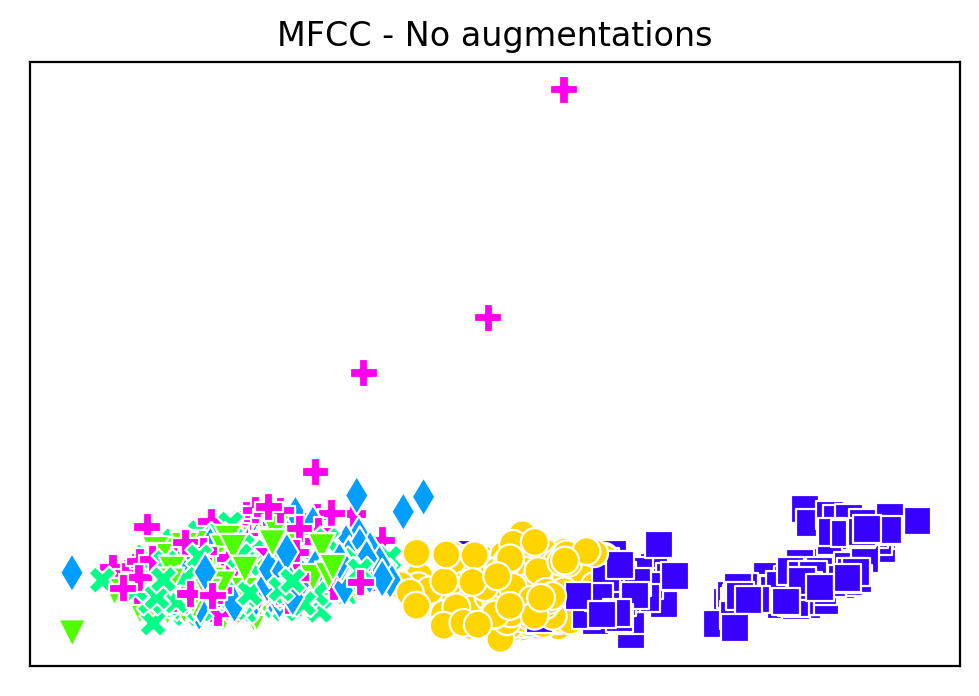

In [9]:
fig, ax = plot_tsne_features(X, true_labels, "MFCC - No augmentations")
fig.savefig(
    ROOT.joinpath("results", "mfcc_no_aug.eps"),
    format="eps",
    bbox_inches="tight",
)

In [10]:
unseen_no_aug_estimator = GaussianMixture.load(
    ROOT.joinpath("checkpoints", "gmm", "mfcc_wihtout_aug")
)

In [11]:
predicted_probabilities = unseen_no_aug_estimator.predict_proba(X).detach().numpy()
predicted_labels = np.argmax(predicted_probabilities, axis=1)

Predicting: 100%|██████████| 5/5 [00:00<00:00, 112.85it/s]


In [12]:
print_scores(true_labels, predicted_labels)


    F1 Score: 0.25
    Accuracy: 0.25
    


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 432x288 with 0 Axes>

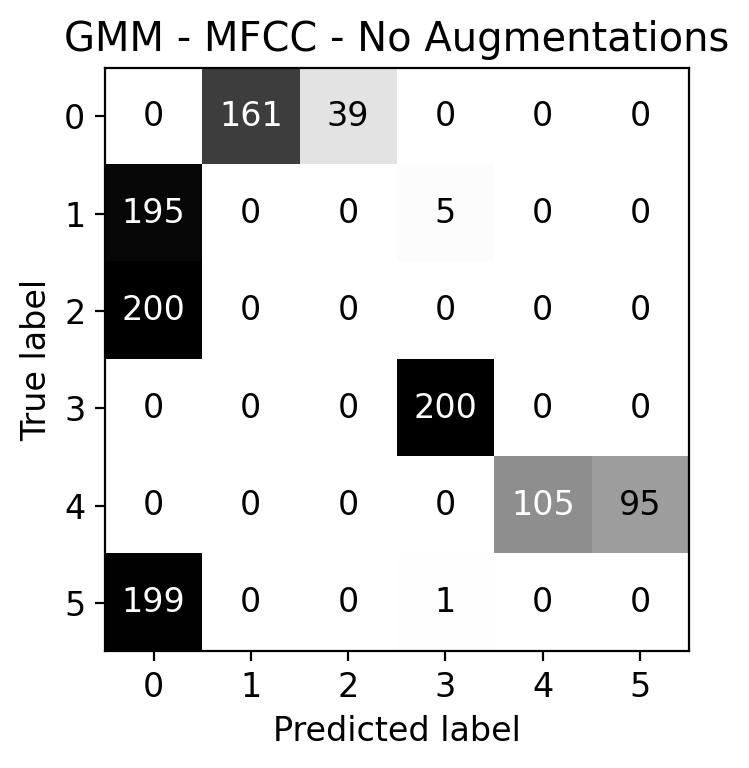

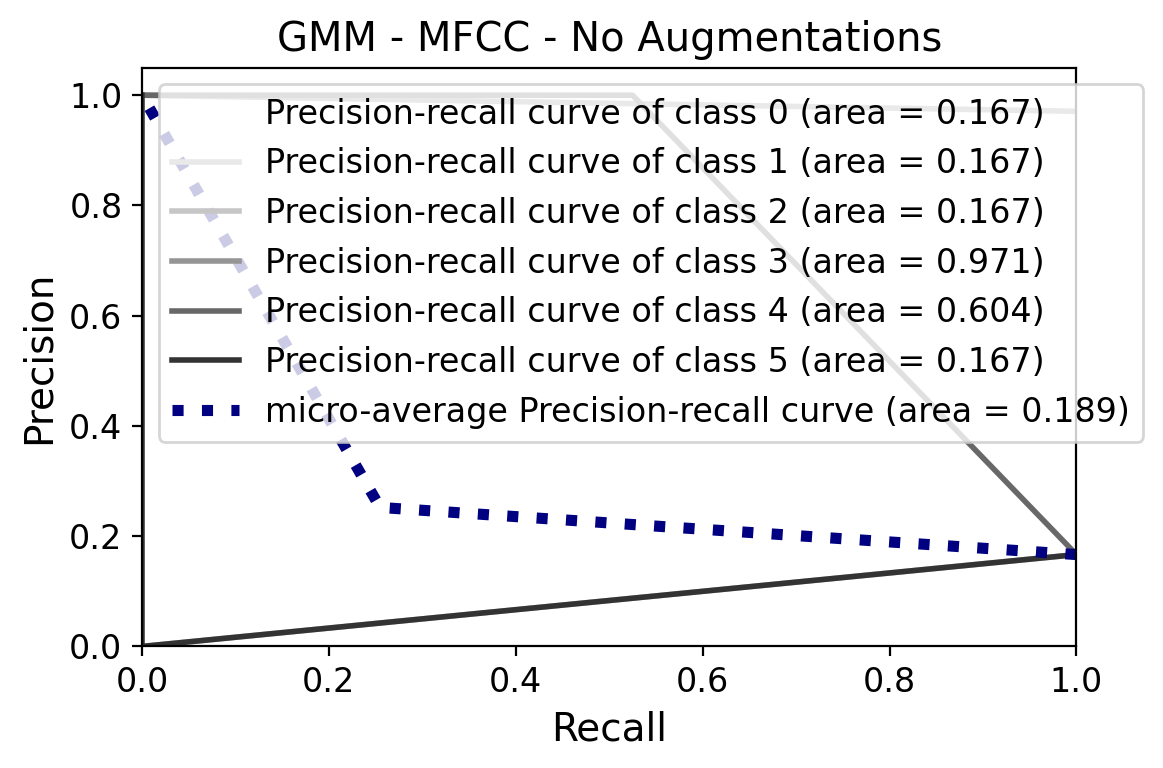

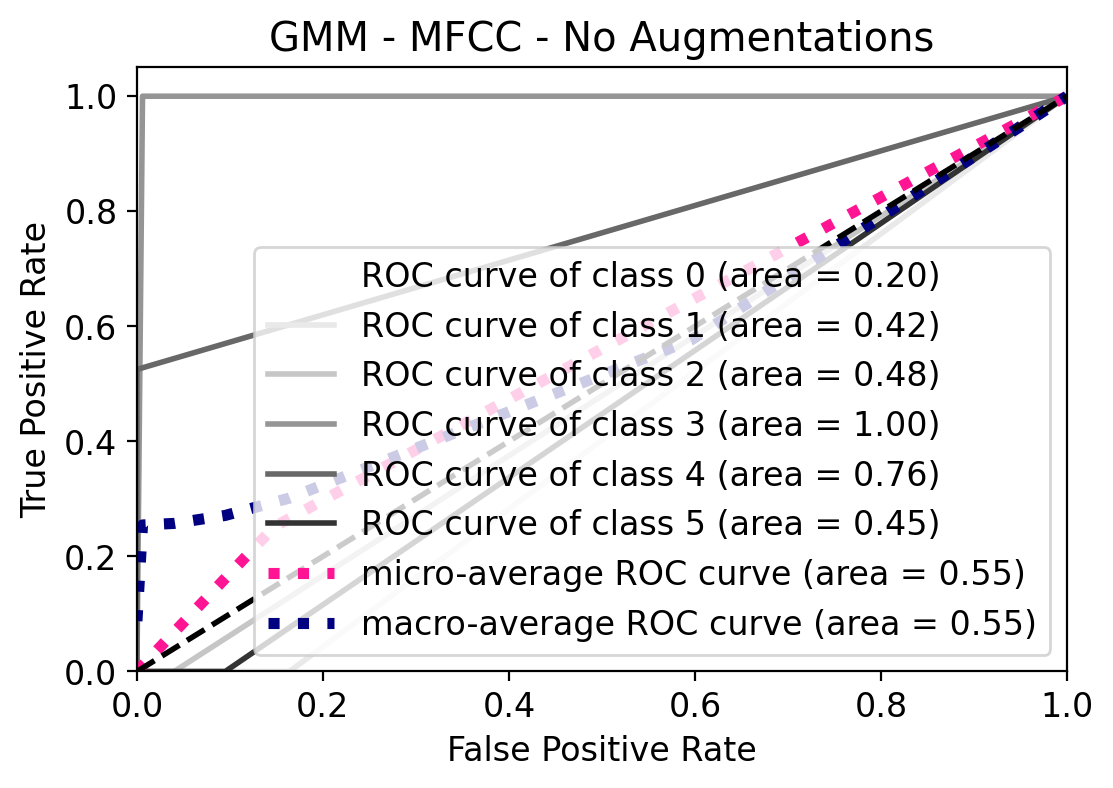

In [14]:
fig_save_path = str(ROOT.joinpath("results", "gmm_mfcc", "with_unseen_no_aug"))
os.makedirs(fig_save_path, exist_ok=True)

plot_classification_report(
    true_labels,
    predicted_labels,
    predicted_probabilities,
    save_path=fig_save_path,
    title_suffix="GMM - MFCC - No Augmentations",
)

#### With augmentations

In [42]:
batch_size = 240

In [43]:
data_module = SPCUP22DataModule(
    batch_size=batch_size,
    dataset_root=str(ROOT.joinpath("data", "raw_audio", "spcup22").absolute()),
    should_include_unseen_in_training_data=True,
    should_include_augmented_data=True,
    transform=transforms,
)
data_module.prepare_data()
data_module.setup()


Skipping downloading [/home/iubnlp/spcup22/SPCUP2022/data/raw_audio/spcup22/spcup_2022_training_part1.zip]...
Skipping downloading [/home/iubnlp/spcup22/SPCUP2022/data/raw_audio/spcup22/spcup_2022_unseen.zip]...
Skipping downloading [/home/iubnlp/spcup22/SPCUP2022/data/raw_audio/spcup22/part1_aug.zip]...
Skipping downloading [/home/iubnlp/spcup22/SPCUP2022/data/raw_audio/spcup22/part2_aug.zip]...
Skipping downloading [/home/iubnlp/spcup22/SPCUP2022/data/raw_audio/spcup22/spcup_2022_eval_part1.zip]...
Skipping downloading [/home/iubnlp/spcup22/SPCUP2022/data/raw_audio/spcup22/spcup_2022_eval_part2.zip]...


In [44]:
test_dataloader = data_module.test_dataloader()
X, true_labels = get_numpy_dataset_from_dataloader(test_dataloader, batch_size, return_true_labels=True)

100%|██████████| 20/20 [13:43<00:00, 41.15s/it]  


<Figure size 432x288 with 0 Axes>

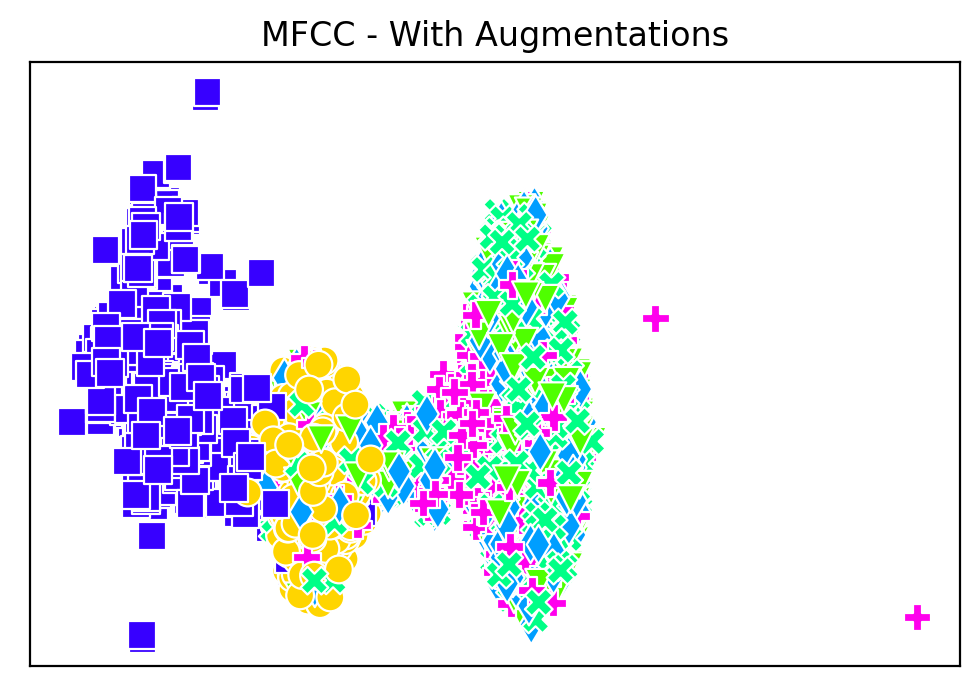

In [45]:
fig, ax = plot_tsne_features(X, true_labels, "MFCC - With Augmentations")
fig.savefig(
    ROOT.joinpath("results", "mfcc_aug.eps"),
    format="eps",
    bbox_inches="tight",
)

In [19]:
unseen_aug_estimator = GaussianMixture.load(
    ROOT.joinpath("checkpoints", "gmm", "mfcc_with_aug")
)

In [22]:
predicted_probabilities = unseen_aug_estimator.predict_proba(X).detach().numpy()
predicted_labels = np.argmax(predicted_probabilities, axis=1)

Predicting: 100%|██████████| 20/20 [00:00<00:00, 210.52it/s]


In [23]:
print_scores(true_labels, predicted_labels)


    F1 Score: 0.39
    Accuracy: 0.39
    


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 432x288 with 0 Axes>

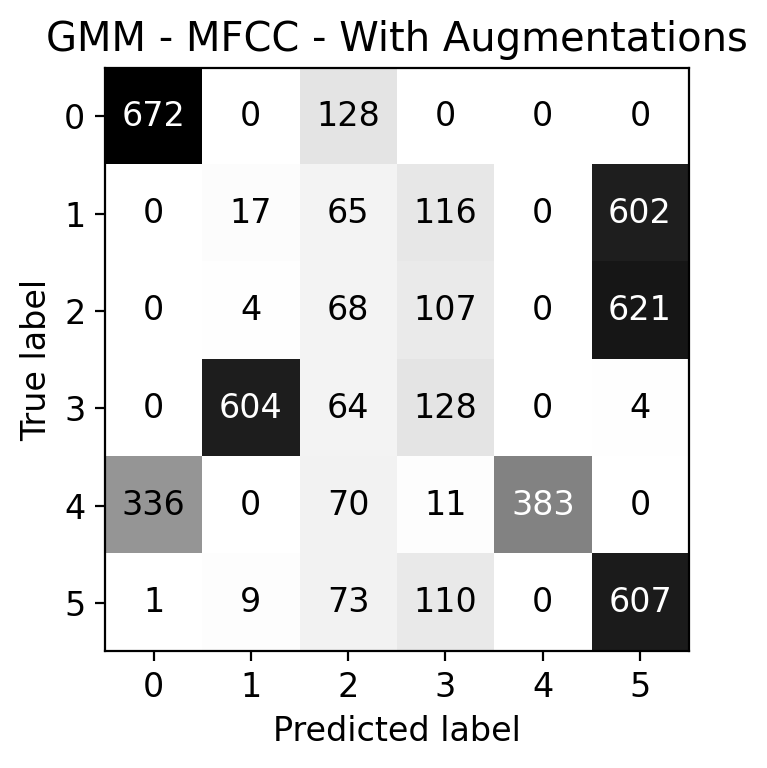

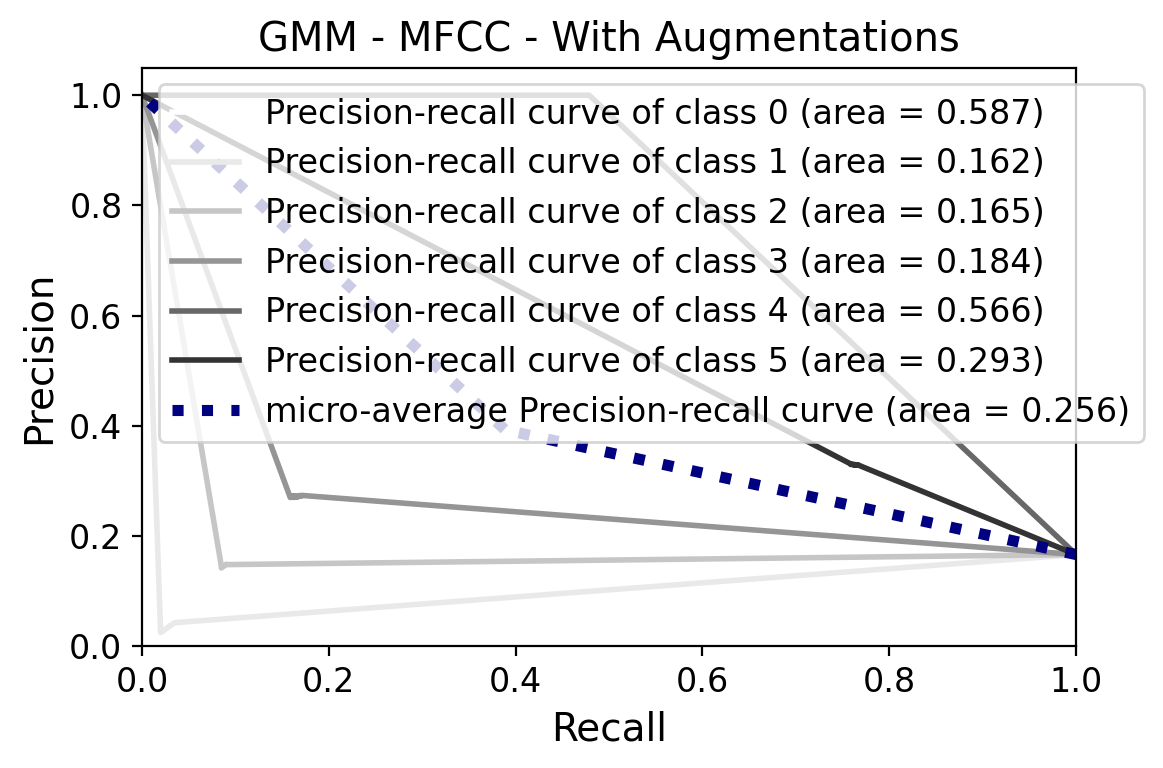

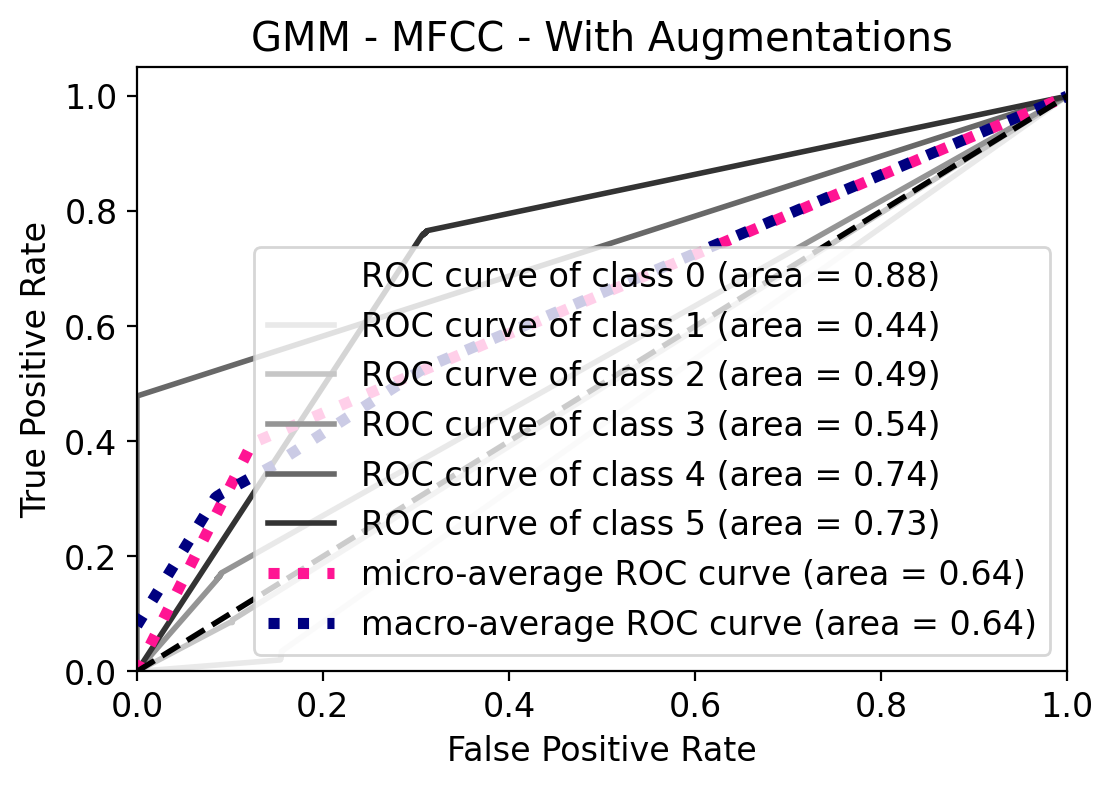

In [24]:
fig_save_path = str(ROOT.joinpath("results", "gmm_mfcc", "with_unseen_aug"))
os.makedirs(fig_save_path, exist_ok=True)

plot_classification_report(
    true_labels,
    predicted_labels,
    predicted_probabilities,
    save_path=fig_save_path,
    title_suffix="GMM - MFCC - With Augmentations",
)

## CQCC

#### Without augmentations

In [25]:
batch_size = 200
cqcc_extractor = CQCC()
transforms = Compose([cqcc_extractor])

In [26]:
data_module = SPCUP22DataModule(
    batch_size=batch_size,
    dataset_root=str(ROOT.joinpath("data", "raw_audio", "spcup22").absolute()),
    should_include_unseen_in_training_data=True,
    should_include_augmented_data=False,
    transform=transforms,
)
data_module.prepare_data()
data_module.setup()

test_dataloader = data_module.test_dataloader()
X, true_labels = get_numpy_dataset_from_dataloader(test_dataloader, batch_size, return_true_labels=True)

Skipping downloading [/home/iubnlp/spcup22/SPCUP2022/data/raw_audio/spcup22/spcup_2022_training_part1.zip]...
Skipping downloading [/home/iubnlp/spcup22/SPCUP2022/data/raw_audio/spcup22/spcup_2022_unseen.zip]...
Skipping downloading [/home/iubnlp/spcup22/SPCUP2022/data/raw_audio/spcup22/part1_aug.zip]...
Skipping downloading [/home/iubnlp/spcup22/SPCUP2022/data/raw_audio/spcup22/part2_aug.zip]...
Skipping downloading [/home/iubnlp/spcup22/SPCUP2022/data/raw_audio/spcup22/spcup_2022_eval_part1.zip]...
Skipping downloading [/home/iubnlp/spcup22/SPCUP2022/data/raw_audio/spcup22/spcup_2022_eval_part2.zip]...
1200


100%|██████████| 6/6 [03:51<00:00, 38.56s/it] 


<Figure size 432x288 with 0 Axes>

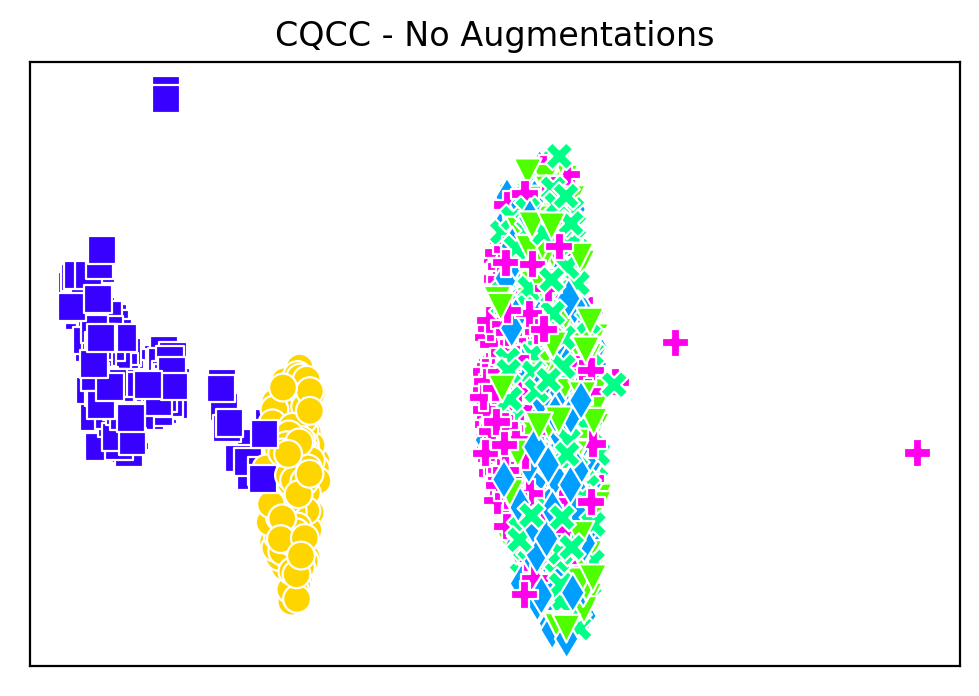

In [27]:
fig, ax = plot_tsne_features(X, true_labels, "CQCC - No Augmentations")
fig.savefig(
    ROOT.joinpath("results", "cqcc_no_aug.eps"),
    format="eps",
    bbox_inches="tight",
)

In [29]:
unseen_no_aug_estimator = GaussianMixture.load(
    ROOT.joinpath("checkpoints", "gmm", "cqcc_without_aug")
)

In [30]:
predicted_probabilities = unseen_no_aug_estimator.predict_proba(X).detach().numpy()
predicted_labels = np.argmax(predicted_probabilities, axis=1)

Predicting: 100%|██████████| 5/5 [00:00<00:00, 188.12it/s]


In [31]:
print_scores(true_labels, predicted_labels)


    F1 Score: 0.20
    Accuracy: 0.20
    


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 432x288 with 0 Axes>

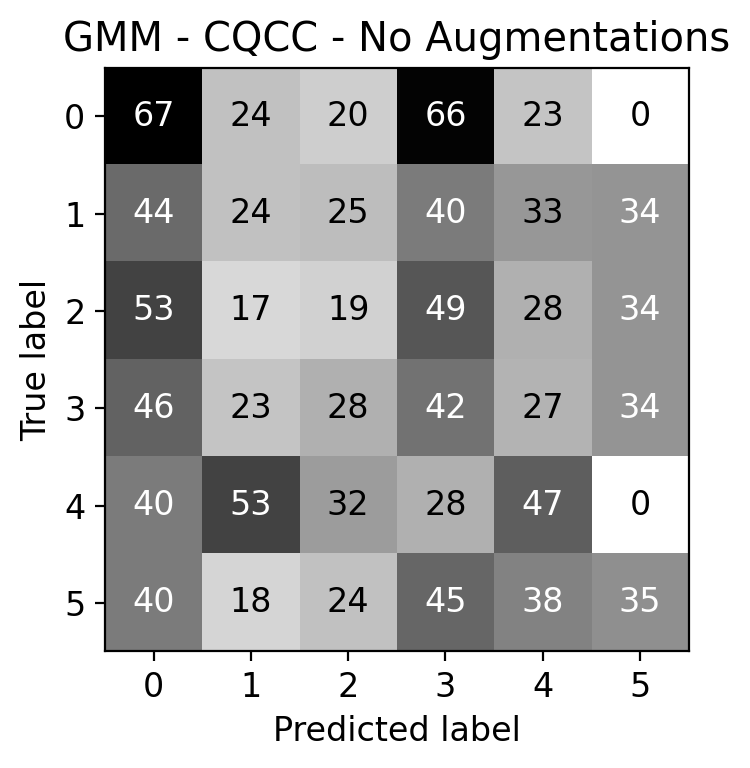

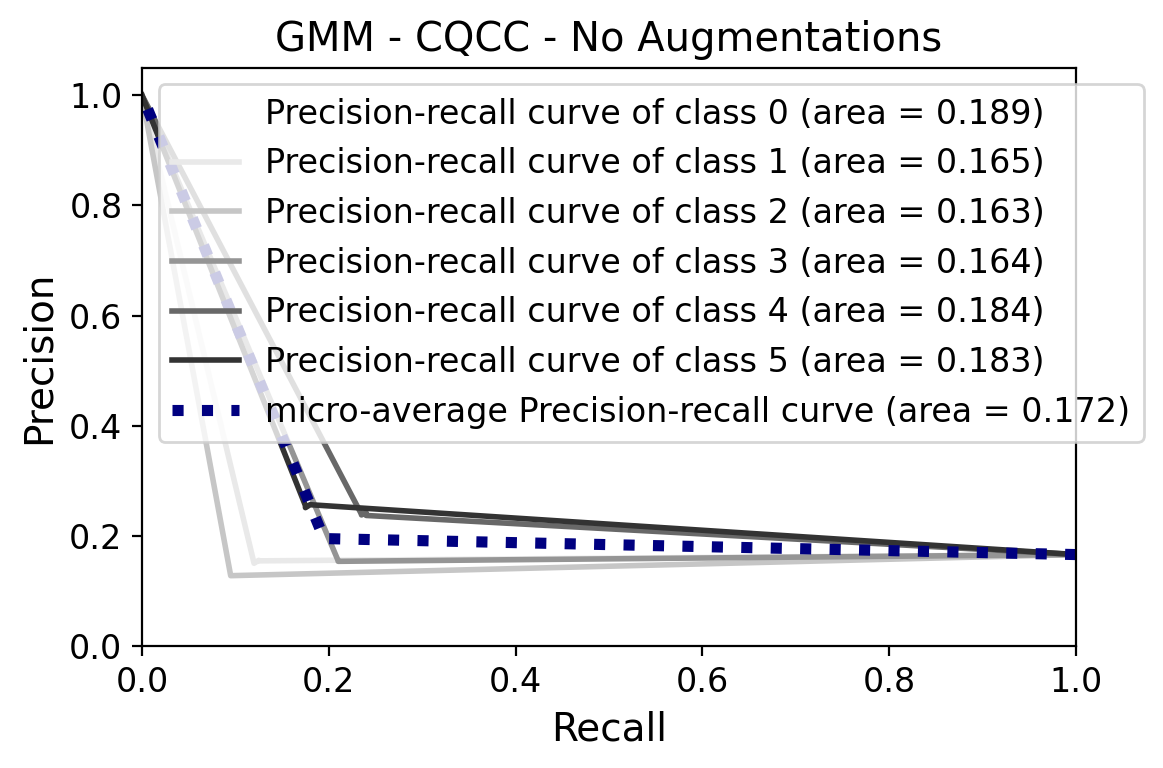

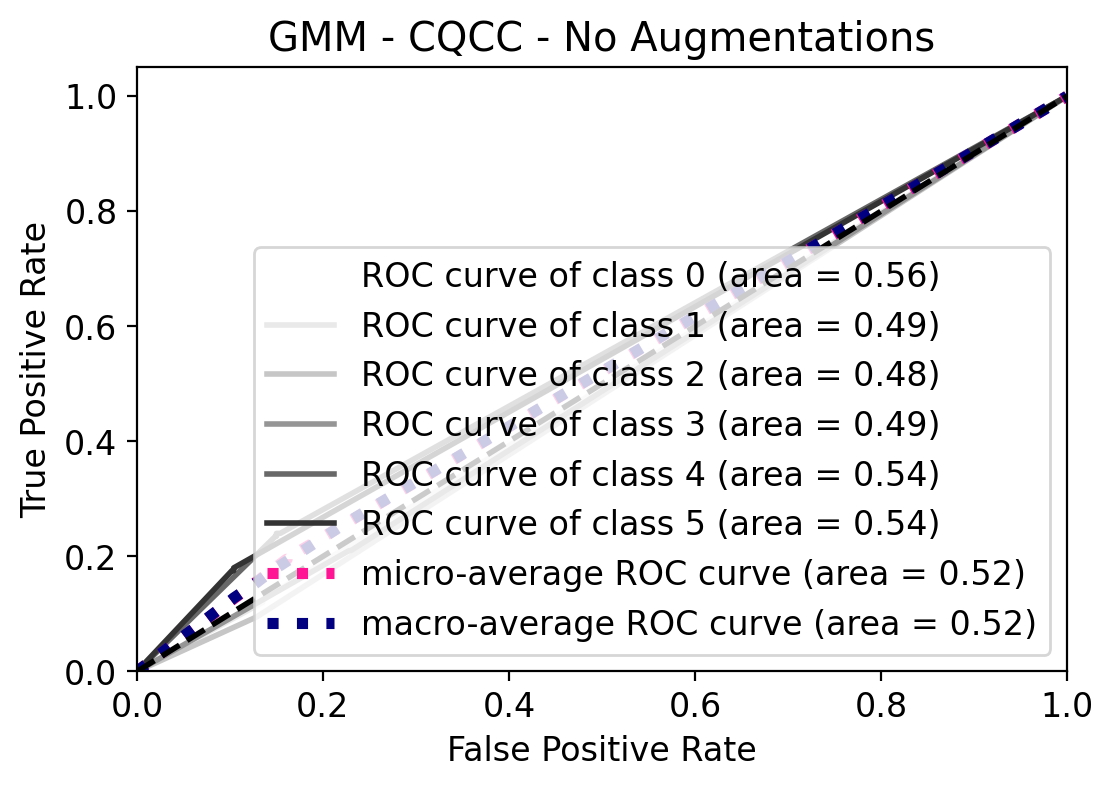

In [32]:
fig_save_path = str(ROOT.joinpath("results", "gmm_cqcc", "cqcc_with_unseen_no_aug"))
os.makedirs(fig_save_path, exist_ok=True)

plot_classification_report(
    true_labels,
    predicted_labels,
    predicted_probabilities,
    title_suffix="GMM - CQCC - No Augmentations",
    save_path=fig_save_path,
)

#### With augmentations

In [33]:
batch_size = 240

In [34]:
data_module = SPCUP22DataModule(
    batch_size=batch_size,
    dataset_root=str(ROOT.joinpath("data", "raw_audio", "spcup22").absolute()),
    should_include_unseen_in_training_data=True,
    should_include_augmented_data=True,
    transform=transforms,
)
data_module.prepare_data()
data_module.setup()

test_dataloader = data_module.test_dataloader()
X, true_labels = get_numpy_dataset_from_dataloader(test_dataloader, batch_size, return_true_labels=True)

Skipping downloading [/home/iubnlp/spcup22/SPCUP2022/data/raw_audio/spcup22/spcup_2022_training_part1.zip]...
Skipping downloading [/home/iubnlp/spcup22/SPCUP2022/data/raw_audio/spcup22/spcup_2022_unseen.zip]...
Skipping downloading [/home/iubnlp/spcup22/SPCUP2022/data/raw_audio/spcup22/part1_aug.zip]...
Skipping downloading [/home/iubnlp/spcup22/SPCUP2022/data/raw_audio/spcup22/part2_aug.zip]...
Skipping downloading [/home/iubnlp/spcup22/SPCUP2022/data/raw_audio/spcup22/spcup_2022_eval_part1.zip]...
Skipping downloading [/home/iubnlp/spcup22/SPCUP2022/data/raw_audio/spcup22/spcup_2022_eval_part2.zip]...


100%|██████████| 20/20 [14:40<00:00, 44.05s/it]  


In [40]:
true_labels.shape

(4800,)

<Figure size 432x288 with 0 Axes>

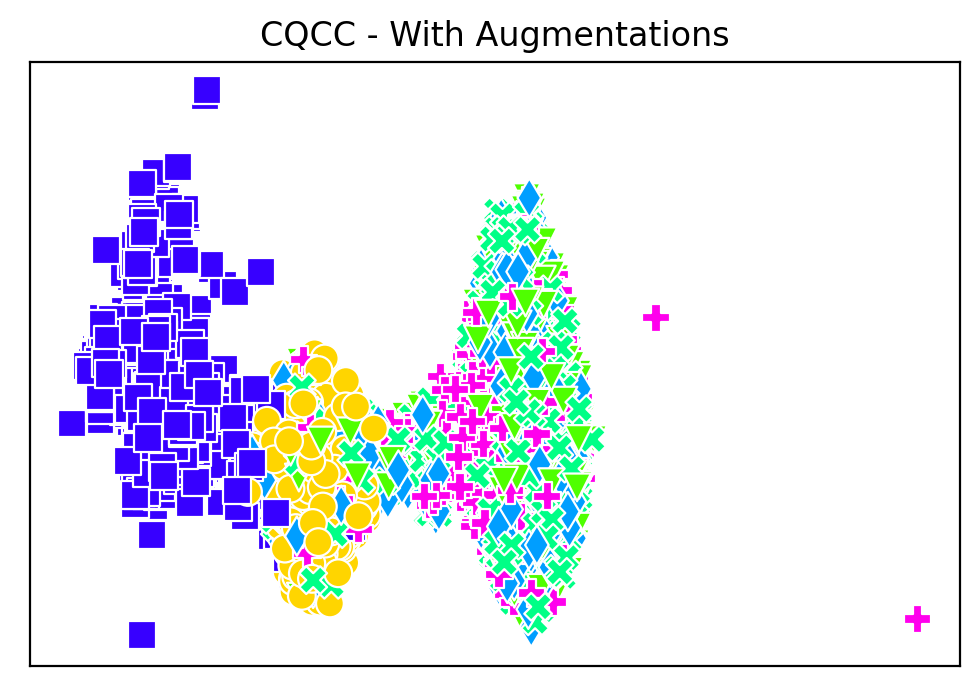

In [35]:
fig, ax = plot_tsne_features(X, true_labels, "CQCC - With Augmentations")
fig.savefig(
    ROOT.joinpath("results", "cqcc_aug.eps"),
    format="eps",
    bbox_inches="tight",
)

Predicting: 100%|██████████| 20/20 [00:00<00:00, 235.75it/s]

    F1 Score: 0.16
    Accuracy: 0.16
    


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 432x288 with 0 Axes>

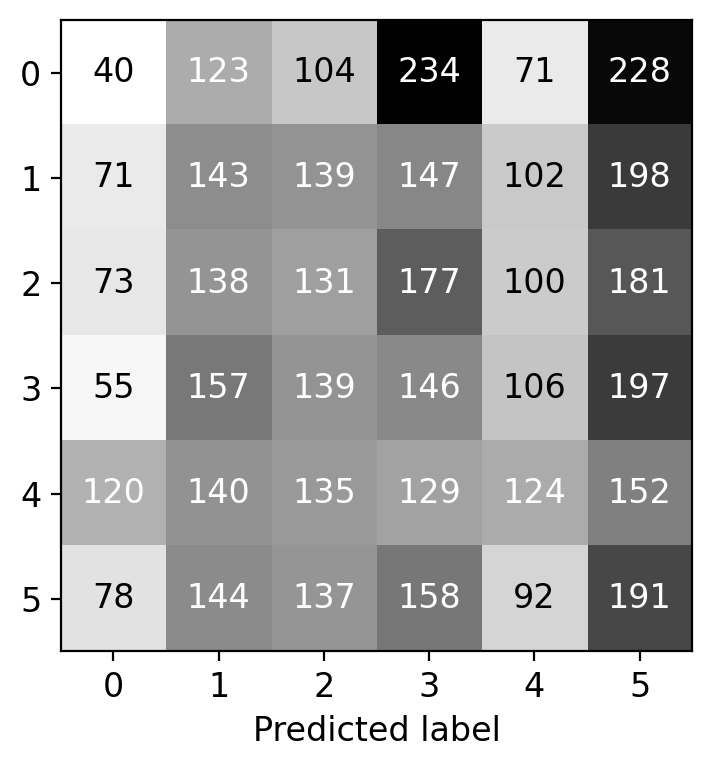

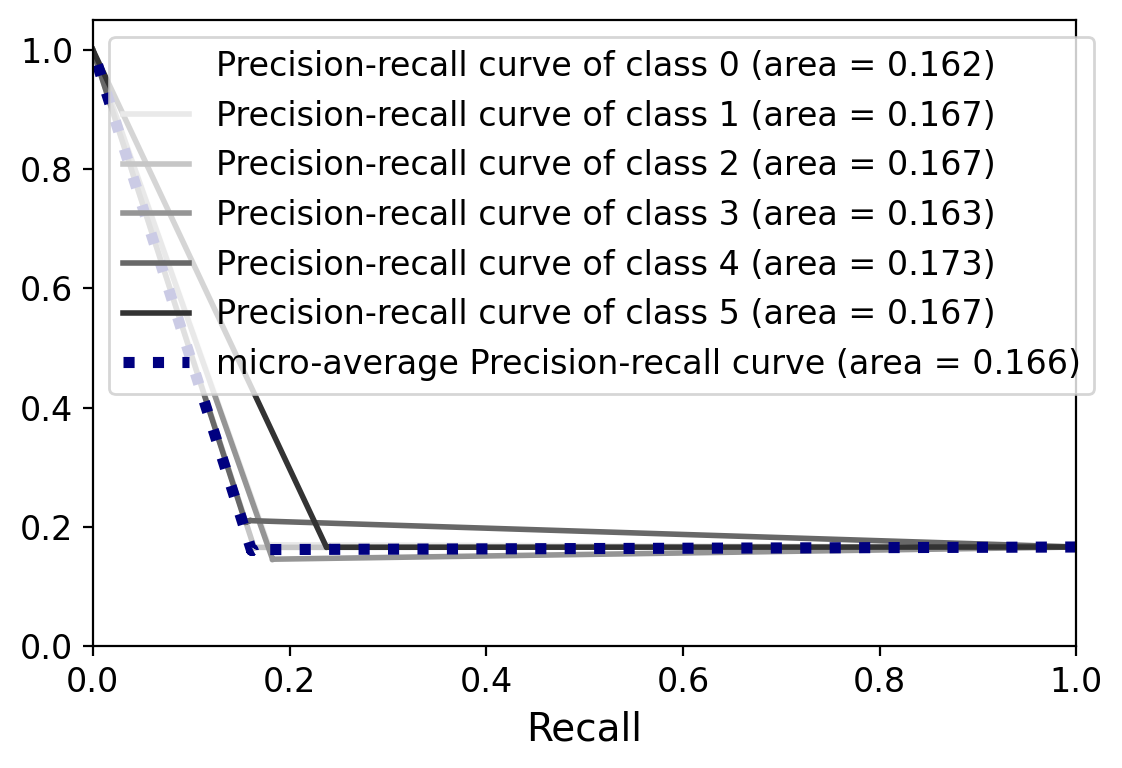

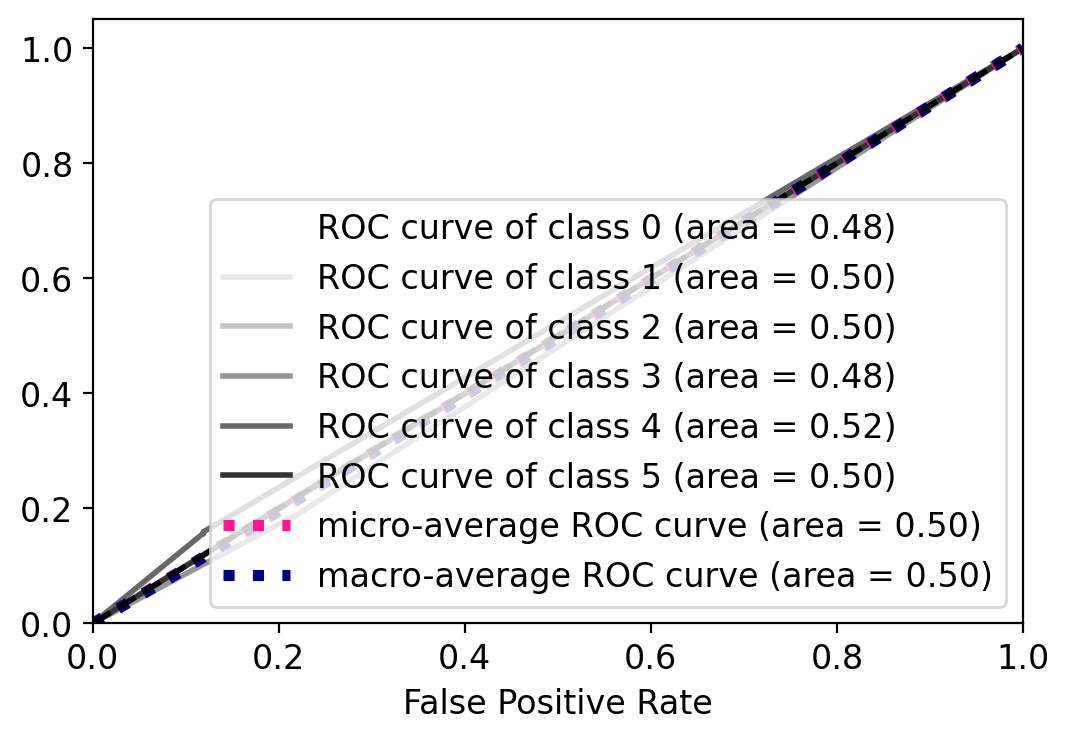

In [21]:
unseen_aug_estimator = GaussianMixture.load(
    ROOT.joinpath("checkpoints", "gmm", "cqcc_with_aug")
)

In [ ]:
predicted_probabilities = unseen_aug_estimator.predict_proba(X).detach().numpy()
predicted_labels = np.argmax(predicted_probabilities, axis=1)

In [ ]:
print_scores(true_labels, predicted_labels)

In [ ]:
fig_save_path = str(ROOT.joinpath("results", "gmm_cqcc", "cqcc_with_unseen_aug"))
os.makedirs(fig_save_path, exist_ok=True)

plot_classification_report(
    true_labels,
    predicted_labels,
    predicted_probabilities,
    title_suffix="GMM - CQCC - With Augmentations",
    save_path=fig_save_path,
)